# LCLS Archiver restore example

These examples show how single snapshots, and time series can be retreived from the archiver appliance.

Note that the times must always be in ISO 8601 format, UTC time (not local time). 


In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# pretty plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (10,6)

In [2]:
from lcls_live.archiver import lcls_archiver_restore
from lcls_live import data_dir
import json
import os

# This is the main function
?lcls_archiver_restore

Signature:
lcls_archiver_restore(
    pvlist,
    isotime='2018-08-11T10:40:00.000-07:00',
    verbose=True,
)
Docstring:
Returns a dict of {'pvname':val} given a list of pvnames, at a time in ISO 8601 format, using the EPICS Archiver Appliance:

https://slacmshankar.github.io/epicsarchiver_docs/userguide.html
File:      ~/Code/GitHub/lcls-live/lcls_live/archiver.py
Type:      function


## Optional: off-site setup

In [3]:
# Optional: 

# Open an SSH tunnel in a terminal like:
# ssh -D 8080 cmayes@rhel6-64.slac.stanford.edu 
# And then set:
os.environ['http_proxy']='socks5h://localhost:8080'
os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
os.environ['ALL_PROXY']='socks5h://localhost:8080'

# Restore known PVs

In [4]:
pvlist = [
          'IRIS:LR20:130:MOTR_ANGLE', 
          'SOLN:IN20:121:BDES',
          'QUAD:IN20:121:BDES',
          'QUAD:IN20:122:BDES',
          'ACCL:IN20:300:L0A_ADES',
          'ACCL:IN20:300:L0A_PDES'
]

lcls_archiver_restore(pvlist, '2020-07-09T05:01:21.000000-07:00')

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2020-07-09T05:01:21.000000-07:00&includeProxies=true


{'IRIS:LR20:130:MOTR_ANGLE': 220.6020050048828,
 'SOLN:IN20:121:BDES': 0.4745,
 'QUAD:IN20:121:BDES': 0.0,
 'QUAD:IN20:122:BDES': 0.0,
 'ACCL:IN20:300:L0A_ADES': 58.5,
 'ACCL:IN20:300:L0A_PDES': 0.0}

## Get snapshot from a large list

Same as above, but for processing large amounts of data

In [5]:
# Get list of PVs
fname = os.path.join(data_dir, 'classic/full_pvlist.json')
pvlist = json.load(open(fname))
pvlist[0:3]

['ACCL:IN20:350:FUDGE', 'ACCL:LI21:180:L1X_S_AV', 'ACCL:LI21:180:L1X_S_PV']

In [6]:
# Simple filename naming
def snapshot_filename(isotime):
    return  'epics_snapshot_'+isotime+'.json'

In [7]:
times = ['2018-03-06T15:21:15.000000-08:00']

lcls_archiver_restore(pvlist[0:10], times[0])

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2018-03-06T15:21:15.000000-08:00&includeProxies=true


{'ACCL:IN20:350:FUDGE': 1.0039740050739583,
 'ACCL:LI21:180:L1X_S_AV': 20.01551950520014,
 'ACCL:LI21:180:L1X_S_PV': -159.9562692633193,
 'ACCL:LI21:1:FUDGE': 0.9916613729353901,
 'ACCL:LI21:1:L1S_S_PV': -26.12494033014282,
 'ACCL:LI22:1:FUDGE': 1.0191546491070553,
 'ACCL:LI24:100:KLY_PDES': 11.508785641181667,
 'ACCL:LI24:200:KLY_PDES': -75.12033429656984,
 'ACCL:LI24:300:KLY_PDES': -31.816975843257694,
 'ACCL:LI25:1:FUDGE': 1.0398871739006177}

In [8]:
%%time
# Make multiple files
root = './data/'
for t in times:
    newdata = lcls_archiver_restore(pvlist, t)
    fname = os.path.join(root, snapshot_filename(t))
    with open(fname, 'w') as f:
        f.write(json.dumps(newdata))
    print('Written:', fname)

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2018-03-06T15:21:15.000000-08:00&includeProxies=true
Written: ./data/epics_snapshot_2018-03-06T15:21:15.000000-08:00.json
CPU times: user 16.6 ms, sys: 3.81 ms, total: 20.4 ms
Wall time: 4.63 s


# Get history of a single PV

This package also has a couple functions for getting the time history data of a pv.

The first, `lcls_archiver_history`, returns the raw data

In [9]:
from lcls_live.archiver import lcls_archiver_history, lcls_archiver_history_dataframe

t_start = '2020-07-09T05:01:15.000000-07:00'
t_end =   '2020-07-09T05:03:00.000000-07:00'

secs, vals = lcls_archiver_history('SOLN:IN20:121:BDES', start=t_start, end=t_end)

secs[0:5], vals[0:5]

http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=SOLN:IN20:121:BDES&from=2020-07-09T05:01:15.000000-07:00&to=2020-07-09T05:03:00.000000-07:00


([1594296071, 1594296075, 1594296079, 1594296084, 1594296088],
 [0.47, 0.47224999999999995, 0.4745, 0.47675, 0.479])

More convenient, is to format this as a pandas dataframe. 

In [10]:
?lcls_archiver_history_dataframe

Signature: lcls_archiver_history_dataframe(pvname, **kwargs)
Docstring: Same as lcls_archiver_history, but returns a dataframe with the index as the time. 
File:      ~/Code/GitHub/lcls-live/lcls_live/archiver.py
Type:      function


In [11]:
df1 = lcls_archiver_history_dataframe('YAGS:IN20:241:YRMS', start=t_start, end=t_end)
df1[0:5]

http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=YAGS:IN20:241:YRMS&from=2020-07-09T05:01:15.000000-07:00&to=2020-07-09T05:03:00.000000-07:00


,YAGS:IN20:241:YRMS
time,
2020-07-09 11:59:48,433.009985
2020-07-09 12:01:15,292.644774
2020-07-09 12:01:19,262.210378
2020-07-09 12:01:23,226.717519
2020-07-09 12:01:28,230.642901


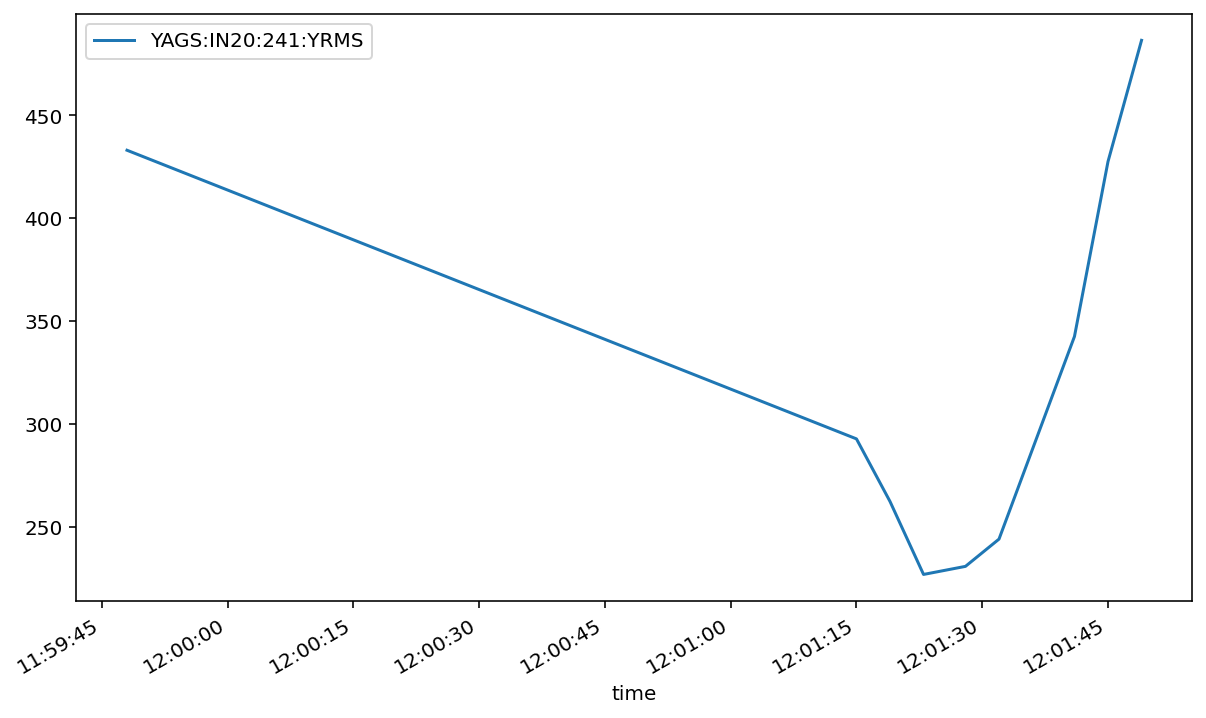

In [12]:
# Pandas has convenient plotting
df1.plot()

# Aligning the history of two PVs

The returned data will not necessarily be time-aligned. Here we will use Pandas' interpolate capabilities to fill in missing data.


In [13]:
import pandas as pd

In [14]:
# Try another PV. This one was smoothy scanned
df2 = lcls_archiver_history_dataframe('SOLN:IN20:121:BDES', start=t_start, end=t_end)
df2

http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=SOLN:IN20:121:BDES&from=2020-07-09T05:01:15.000000-07:00&to=2020-07-09T05:03:00.000000-07:00


,SOLN:IN20:121:BDES
time,
2020-07-09 12:01:11,0.470000
2020-07-09 12:01:15,0.472250
2020-07-09 12:01:19,0.474500
2020-07-09 12:01:24,0.476750
2020-07-09 12:01:28,0.479000
2020-07-09 12:01:32,0.481250
2020-07-09 12:01:37,0.483500
2020-07-09 12:01:41,0.485750
2020-07-09 12:01:46,0.488000


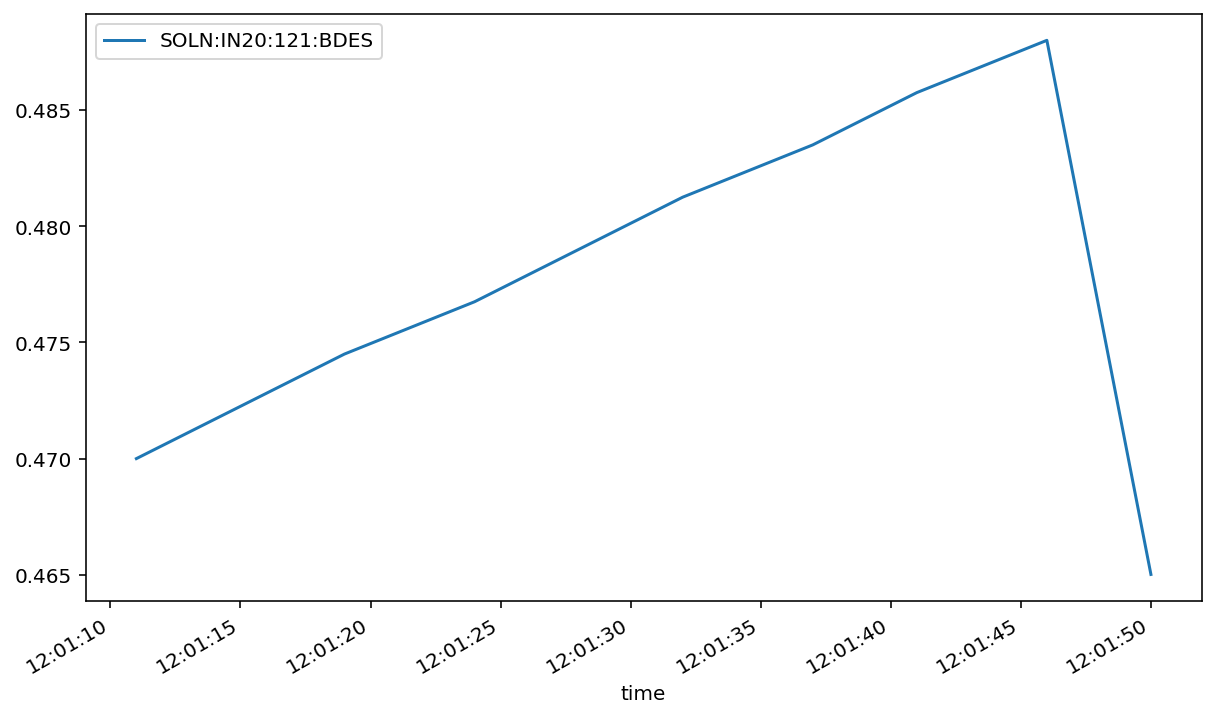

In [15]:
df2.plot()

In [16]:
# Notice that some data are taken at the same time, others are not
df4 = pd.concat([df1, df2], axis=1)
df4

,YAGS:IN20:241:YRMS,SOLN:IN20:121:BDES
time,,
2020-07-09 11:59:48,433.009985,NaN
2020-07-09 12:01:11,NaN,0.470000
2020-07-09 12:01:15,292.644774,0.472250
2020-07-09 12:01:19,262.210378,0.474500
2020-07-09 12:01:23,226.717519,NaN
2020-07-09 12:01:24,NaN,0.476750
2020-07-09 12:01:28,230.642901,0.479000
2020-07-09 12:01:32,243.905289,0.481250
2020-07-09 12:01:37,NaN,0.483500


In [17]:
# This will fill in the missing  values, and drop trailing NaNs
df5 = df4.interpolate().dropna()
df5

,YAGS:IN20:241:YRMS,SOLN:IN20:121:BDES
time,,
2020-07-09 12:01:11,362.827380,0.470000
2020-07-09 12:01:15,292.644774,0.472250
2020-07-09 12:01:19,262.210378,0.474500
2020-07-09 12:01:23,226.717519,0.475625
2020-07-09 12:01:24,228.680210,0.476750
2020-07-09 12:01:28,230.642901,0.479000
2020-07-09 12:01:32,243.905289,0.481250
2020-07-09 12:01:37,293.172623,0.483500
2020-07-09 12:01:41,342.439957,0.485750


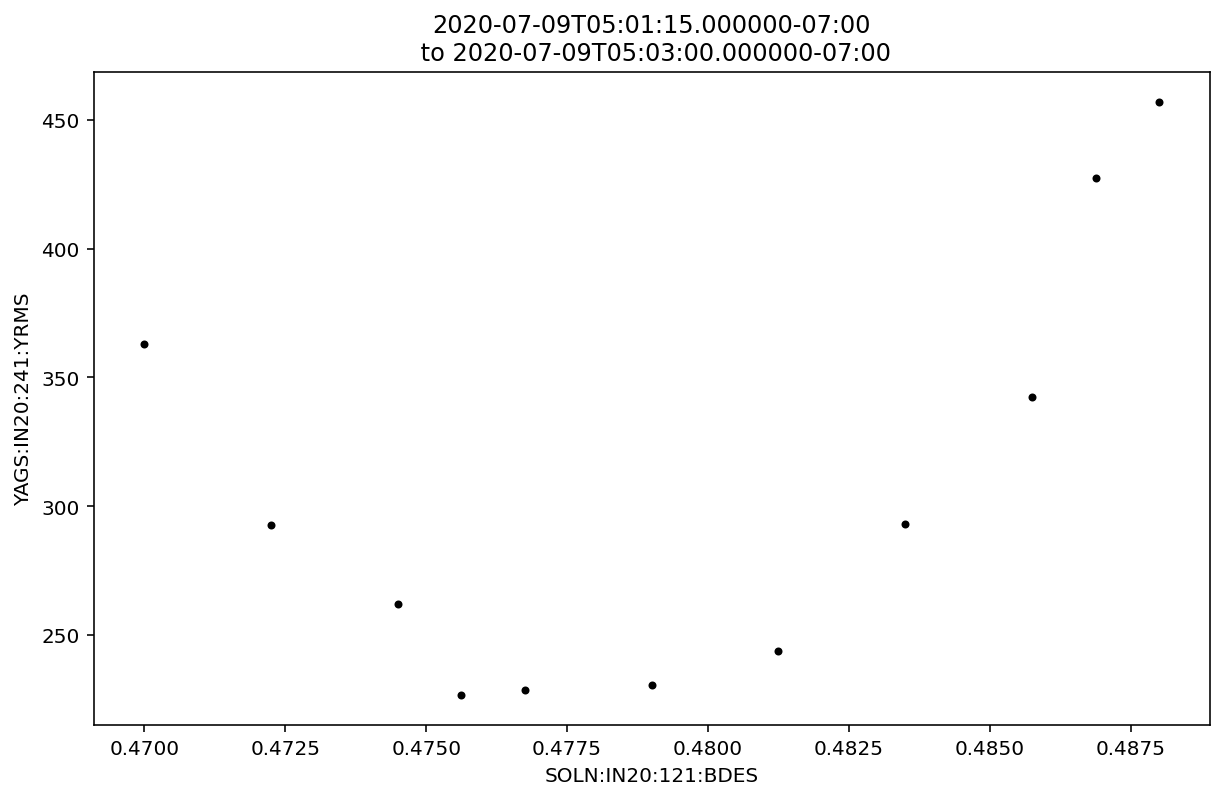

In [18]:
# make a plot
DF = df5[:-2] # The last two points are outside the main scan. 
k1 = 'SOLN:IN20:121:BDES'
k2 = 'YAGS:IN20:241:YRMS'
plt.xlabel(k1)
plt.ylabel(k2)
plt.title(t_start+'\n to '+t_end)
plt.scatter(DF[k1], DF[k2], marker='.', color='black')

# This easily extends to a list

In [19]:
pvlist = ['SOLN:IN20:121:BDES', 'YAGS:IN20:241:XRMS', 'YAGS:IN20:241:YRMS']

dflist = []
for pvname in pvlist:
    dflist.append(lcls_archiver_history_dataframe(pvname, start=t_start, end=t_end))
df6 = pd.concat(dflist, axis=1).interpolate().dropna()

http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=SOLN:IN20:121:BDES&from=2020-07-09T05:01:15.000000-07:00&to=2020-07-09T05:03:00.000000-07:00
http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=YAGS:IN20:241:XRMS&from=2020-07-09T05:01:15.000000-07:00&to=2020-07-09T05:03:00.000000-07:00
http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=YAGS:IN20:241:YRMS&from=2020-07-09T05:01:15.000000-07:00&to=2020-07-09T05:03:00.000000-07:00


In [20]:
df6 

,SOLN:IN20:121:BDES,YAGS:IN20:241:XRMS,YAGS:IN20:241:YRMS
time,,,
2020-07-09 12:01:11,0.470000,393.366373,362.827380
2020-07-09 12:01:15,0.472250,325.602016,292.644774
2020-07-09 12:01:19,0.474500,297.144936,262.210378
2020-07-09 12:01:23,0.475625,269.941236,226.717519
2020-07-09 12:01:24,0.476750,262.813117,228.680210
2020-07-09 12:01:28,0.479000,255.684997,230.642901
2020-07-09 12:01:32,0.481250,246.747285,243.905289
2020-07-09 12:01:36,0.482375,266.423525,276.750178
2020-07-09 12:01:37,0.483500,279.129956,309.595068


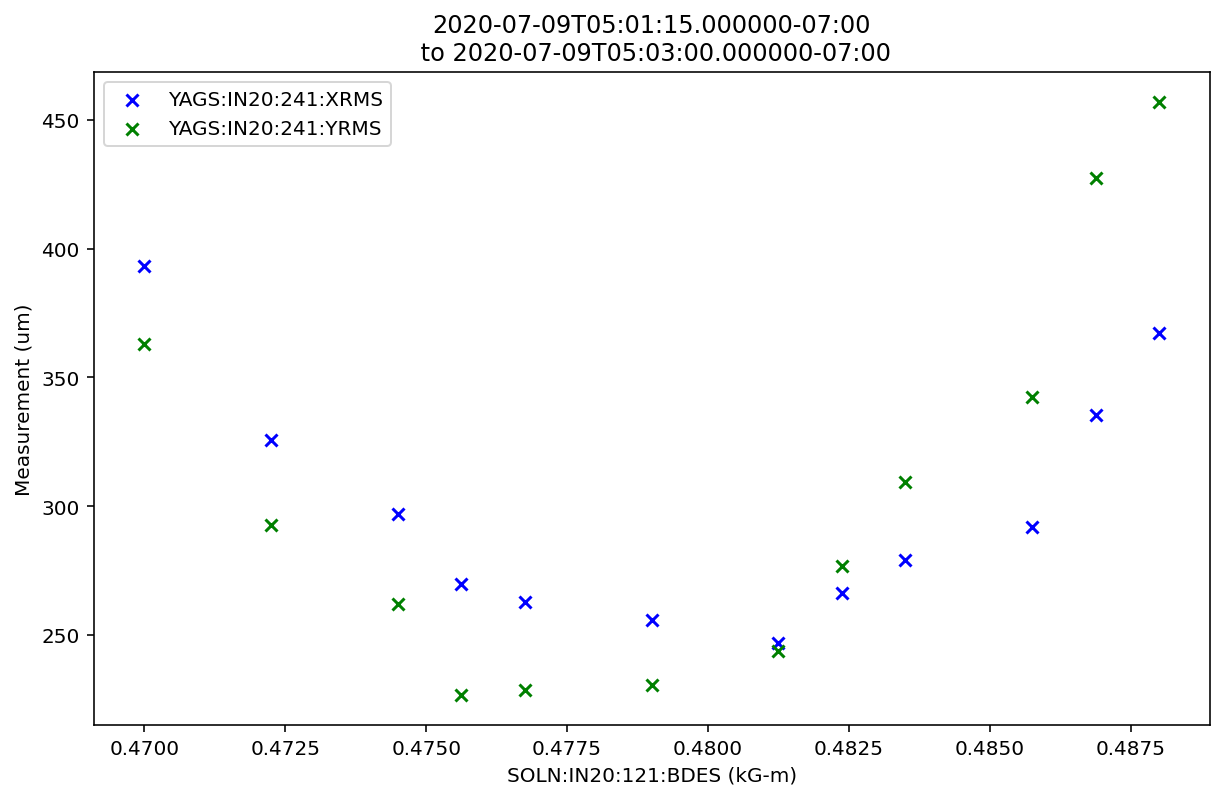

In [21]:
DF = df6[:-2] # Drop the last two that are unrelated to the scan
k1 = 'SOLN:IN20:121:BDES'
k2 = 'YAGS:IN20:241:XRMS'
k3 = 'YAGS:IN20:241:YRMS'
plt.xlabel(k1+' (kG-m)')
plt.ylabel('Measurement (um)')
plt.title(t_start+'\n to '+t_end)

X1 = DF[k1]
X2 = DF[k2]
X3 = DF[k3]

plt.scatter(X1, X2, marker='x', color='blue', label=k2)
plt.scatter(X1, X3, marker='x', color='green', label=k3)
plt.legend()